---
title: "Lagged Sentiment Clustering"
format:
  html:
    embed-resources: true
    code-fold: true
execute:
  warning: false
  message: false
---

This section explores the role of historical sentiment data from the second half of 2023 in predicting customer behavior and insurance choices in 2024. By combining lagged sentiment scores with external auto insurance metrics, clustering algorithms were employed to identify distinct customer segments and analyze the relationship between past sentiments and later behaviors. This analysis directly addresses our second research question: **How do past customer sentiments (lagged sentiments) predict or relate to customer segments based on their later behavior and insurance choices?** 

In [ ]:
%matplotlib inline

In [74]:
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

## Variable Selection

The dataset comprises customer information, insurance policy attributes, and lagged sentiment scores for 2023, combined with behavioral data from 2024. To ensure data readiness, we:

- Checked for multicollinearity and filtered variables with low variance.
- Performed Random Forest feature selection to identify variables most influential for sentiment analysis.

In [75]:
import pandas as pd

# Read a Parquet file
df = pd.read_csv('../../data/cleaned_data/lagged_second_half_merged.csv')
pd.set_option('display.max_columns', None)

# Display the DataFrame
df.head()
 

Unnamed: 0 Customer       state  Customer Lifetime Value Response  \
0           1  SJ95423     Arizona                 11905.68      Yes   
1           2  DP45816     Arizona                 15712.20       No   
2           3  IC13702  California                  9407.26       No   
3           4  JT52858      Oregon                 12187.62       No   
4           5  CE56187      Oregon                  5890.22       No   

   Coverage  Coverage Index             Education  Education Index  \
0     Basic               0  High School or Below                0   
1  Extended               1  High School or Below                0   
2     Basic               0              Bachelor                2   
3   Premium               2              Bachelor                2   
4     Basic               0                Master                3   

  Employment Status  Employment Status Index Gender  Income  Location  \
0          Employed                        1      M  134791  Suburban   
1          Employed                        1      F   83006     Urban   
2        Unemployed                        0      F       0  Suburban   
3          Employed                        1      F  133653  Suburban   
4          Employed                        1      F   73594     Urban   

   Location Index Marital Status  Marital Status Index  Monthly Premium Auto  \
0               1        Married                     1                   149   
1               2        Married                     1                   131   
2               1         Single                     0                    93   
3               1        Married                     1                   151   
4               2       Divorced                     2                   147   

   Months Since Last Claim  Months Since Policy Inception  \
0                       31                             34   
1                        7                             88   
2                       45                             82   
3                       45                            101   
4                        7                             49   

   Number of Open Complaints  Number of Policies     Policy Type  \
0                          1                   8  Corporate Auto   
1                          0                   2   Personal Auto   
2                          1                   2   Personal Auto   
3                          1                   8   Personal Auto   
4                          3                   1   Personal Auto   

   Policy Type Index        Policy  Policy Index  Renew Offer Type  \
0                  1  Corporate L3             5                 2   
1                  0   Personal L3             2                 4   
2                  0   Personal L3             2                 1   
3                  0   Personal L1             0                 3   
4                  0   Personal L2             1                 2   

  Sales Channel  Sales Channel Index  Total Claim Amount  Vehicle Class  \
0        Branch                    1              712.80            SUV   
1        Branch                    1              628.10   Two-Door Car   
2         Agent                    2              670.68  Four-Door Car   
3        Branch                    1              725.76  Four-Door Car   
4        Branch                    1              386.42            SUV   

   Vehicle Class Index Vehicle Size  Vehicle Size Index  month  year  \
0                    4      Medsize                   1     10  2024   
1                    0        Small                   0     10  2024   
2                    1        Small                   0     10  2024   
3                    1      Medsize                   1     10  2024   
4                    4      Medsize                   1     10  2024   

   lagged_avg_sentiment_score lagged_avg_sentiment  
0                   -0.275080             Negative  
1                   -0.275080             

### Correlation Matrix

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

In [77]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/3752379325.py:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



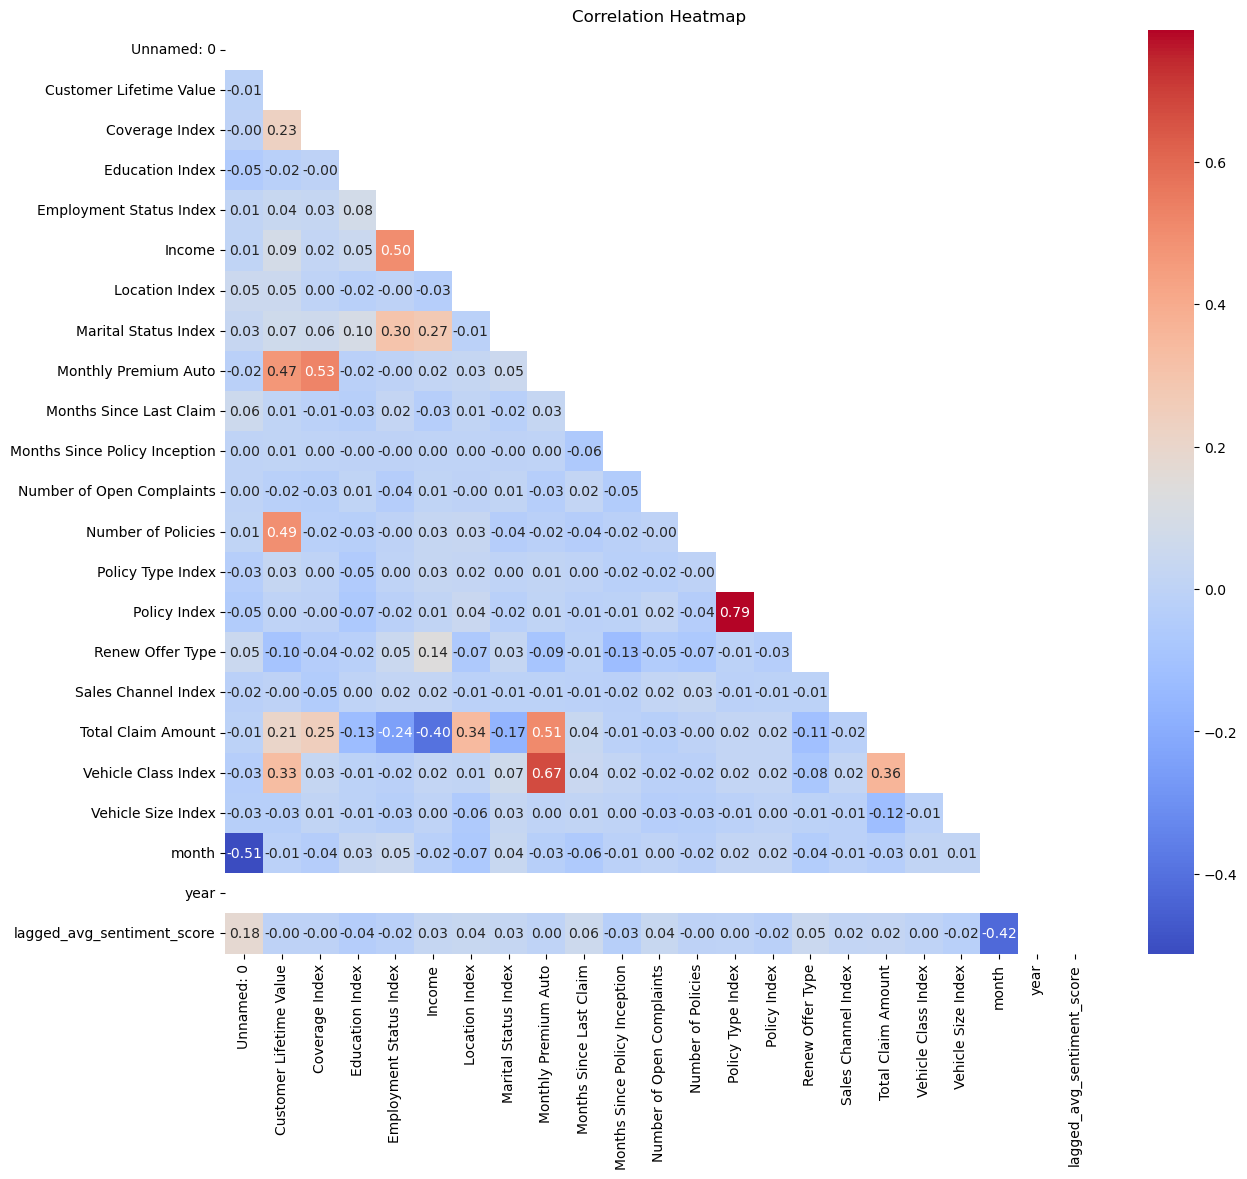

In [78]:
# Compute the correlation matrix
correlation_matrix = df.corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Create a heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


### Filtering Out Variables with Low Variance

In [79]:
# Check standard deviation
low_variance_cols = df.std()[df.std() < 0.3].index

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/2297742091.py:2: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/2297742091.py:2: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



In [80]:
print("Low variance columns:", low_variance_cols)

Low variance columns: Index(['year', 'lagged_avg_sentiment_score'], dtype='object')


### Feature Selection

In [81]:
df_numeric = df.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

X = df_numeric.drop(['Unnamed: 0', 'lagged_avg_sentiment_score', 'year', 'month'], axis=1)
y = df['lagged_avg_sentiment']

# Encode categorical target variable
le = LabelEncoder()
y = le.fit_transform(y)

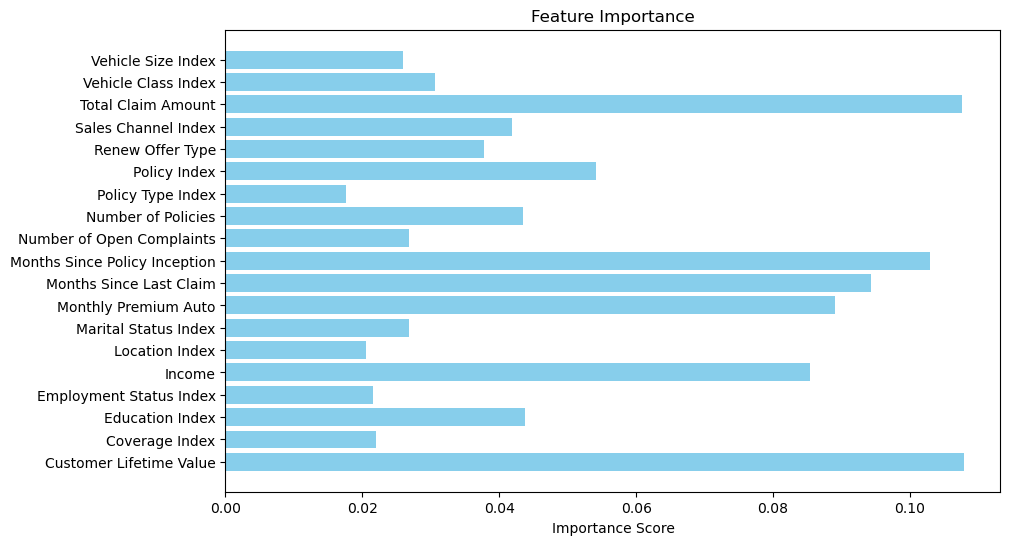

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_test_scaled)

# Feature importance from the model
importances = rf.feature_importances_
features = X.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.show()

In [83]:
# Feature importance and corresponding features
feature_importances = {
'Customer Lifetime Value': 0.1078197162706497,
'Coverage Index': 0.021983766542722275,
'Education Index': 0.0438022231745862,
'Employment Status Index': 0.021578314932309814,
'Income': 0.08533880836102012,
'Location Index': 0.02057917406542304,
'Marital Status Index': 0.026878443379556395,
'Monthly Premium Auto': 0.08902222517414524,
'Months Since Last Claim': 0.09424962486220208,
'Months Since Policy Inception': 0.10292679555348216,
'Number of Open Complaints': 0.026825888624876497,
'Number of Policies': 0.0434765546161667,
'Policy Type Index': 0.017613337550058984,
'Policy Index': 0.05412930771195091,
'Renew Offer Type': 0.03774035239650668,
'Sales Channel Index': 0.041876868596344895,
'Total Claim Amount': 0.10764063070424754,
'Vehicle Class Index': 0.030534956323217705,
'Vehicle Size Index': 0.02598301116053306
}


In [93]:
# Convert to a pandas DataFrame for easier manipulation
df_importance = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Sort by importance
df_importance = df_importance.sort_values(by='Importance', ascending=False)

# Choose top N features (let's select the top 10 for example)
selected_features = df_importance['Feature'].head(10).values
print(selected_features)

['Customer Lifetime Value' 'Total Claim Amount'
 'Months Since Policy Inception' 'Months Since Last Claim'
 'Monthly Premium Auto' 'Income' 'Policy Index' 'Education Index'
 'Number of Policies' 'Sales Channel Index']


Using a Random Forest model, we identified variables that significantly influence sentiment scores. The top features include `Customer Lifetime Value`, `Total Claim Amount`, `Monthly Premium Auto`, `Income`, `Policy`, `Education`. We also wanted to explore other variables, so we added several variables that would be interesting, such as `Vehicle Class` and `Marital Status`.

### Distributions of the Variables by Cluster

To validate these variables' effectiveness in clustering, we analyzed their distributions across clusters using boxplots for numerical variables and bar plots for categorical variables.

- `Income`, `Customer Lifetime Value`, and `Policy` showed distinct distributions across clusters, indicating their potential in differentiating groups.
- `Vehicle Class` and `Marital Status` further contributed to meaningful segmentation.


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



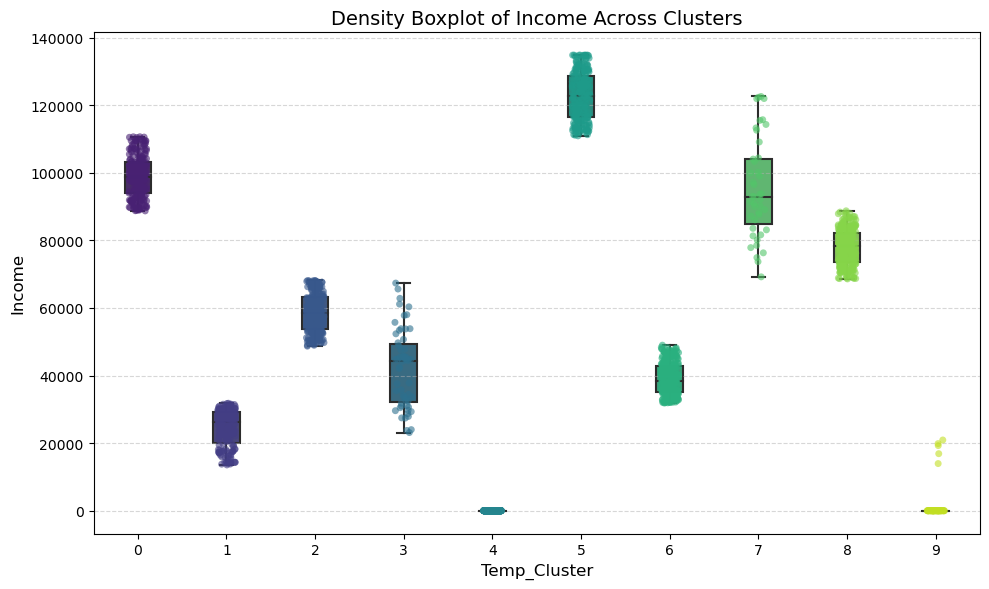

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



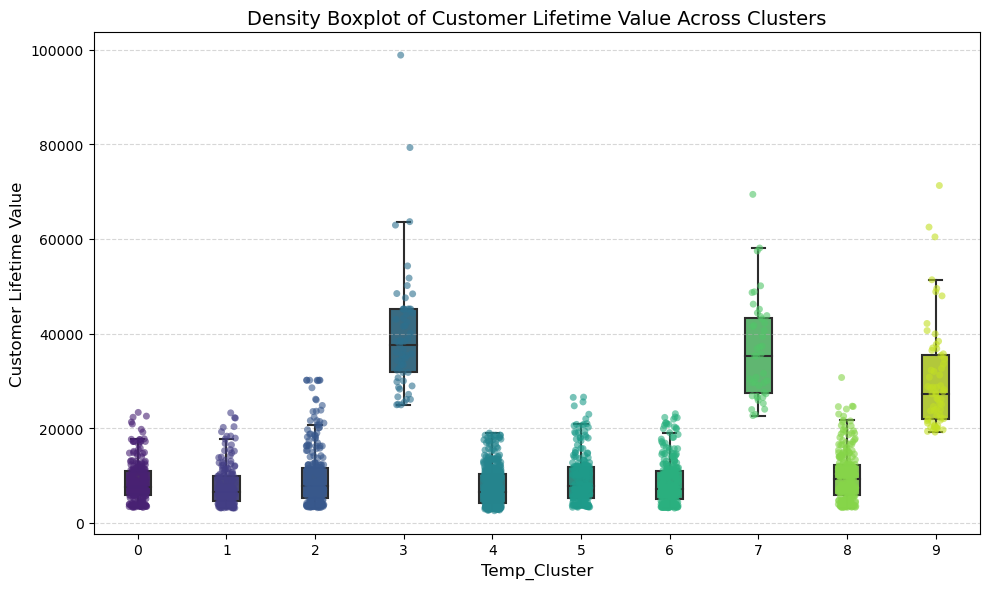

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



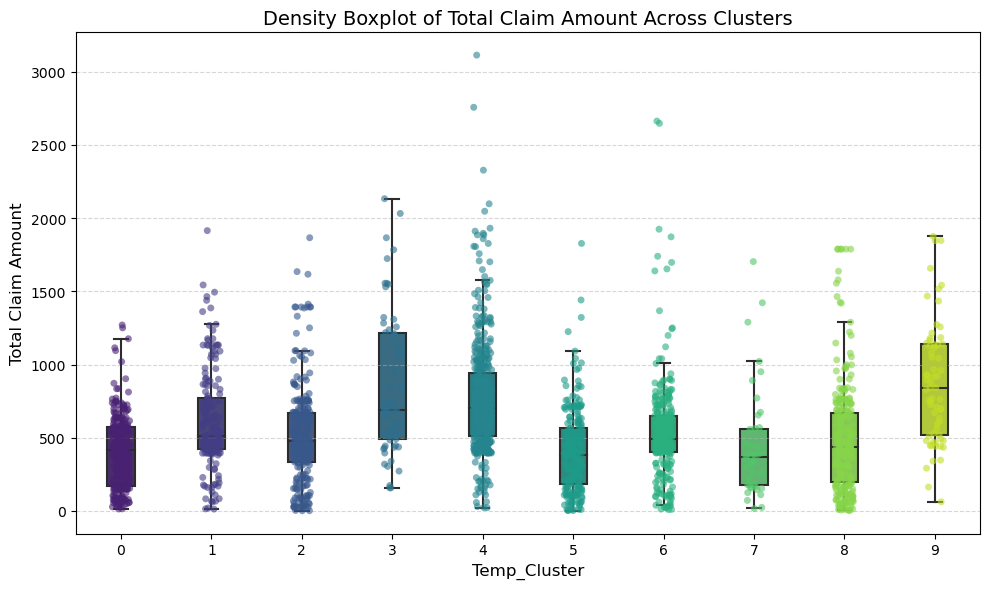

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



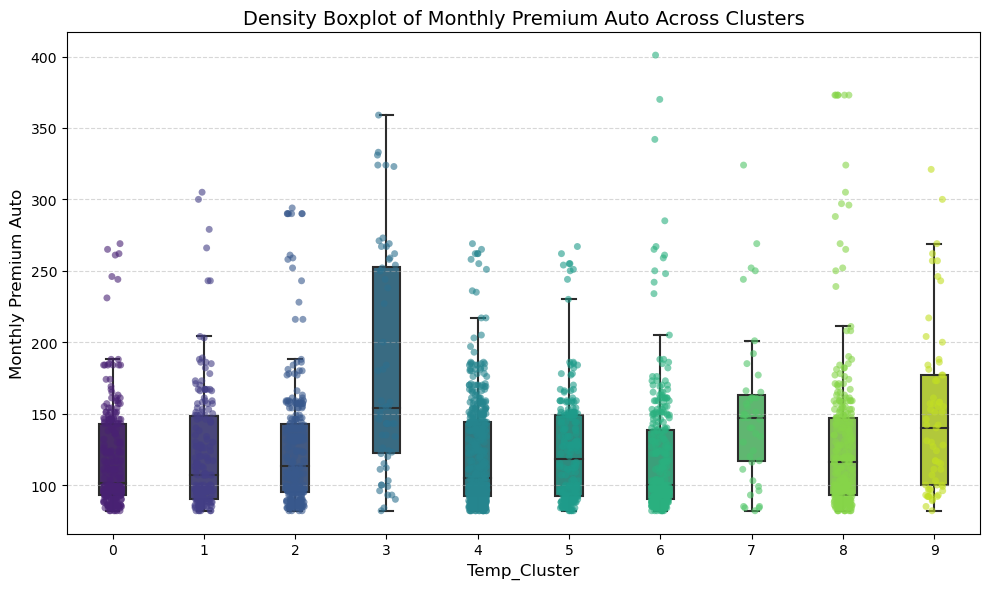

/var/folders/jb/_57y0k0x0wj5rxjpxc000yxc0000gn/T/ipykernel_58064/1752800897.py:18: FutureWarning:

Passing `palette` without assigning `hue` is deprecated.



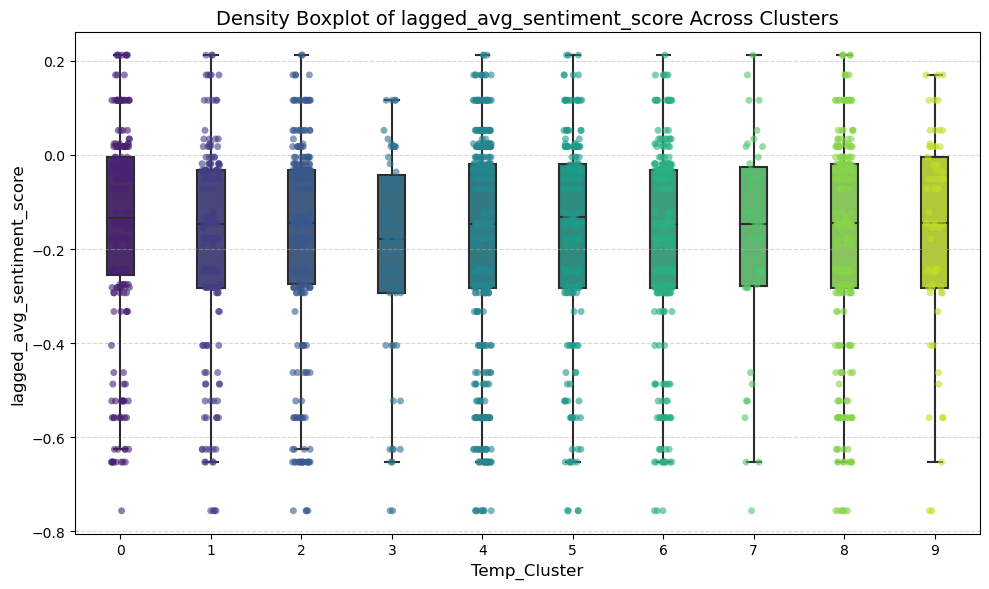

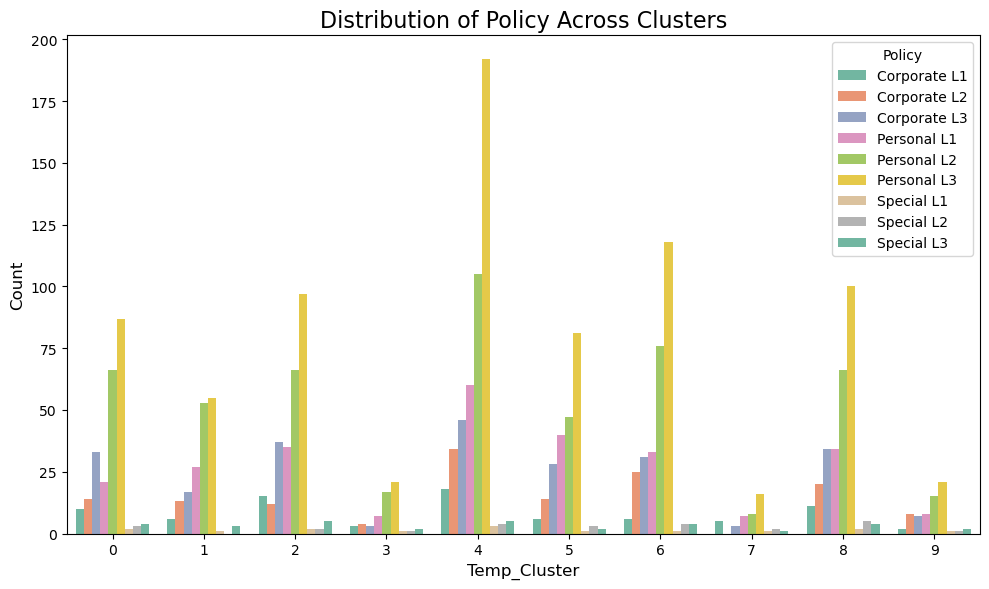

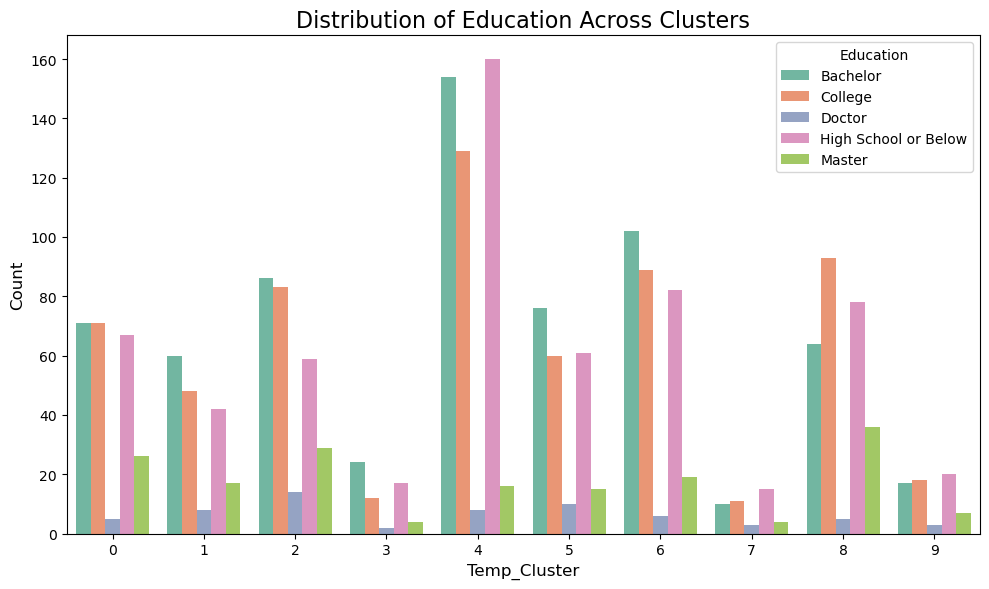

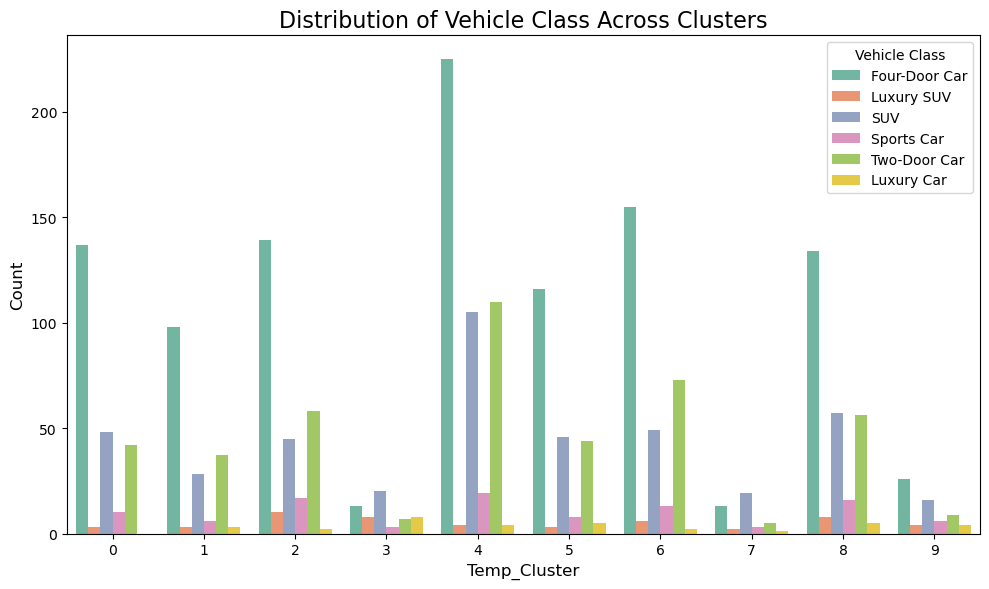

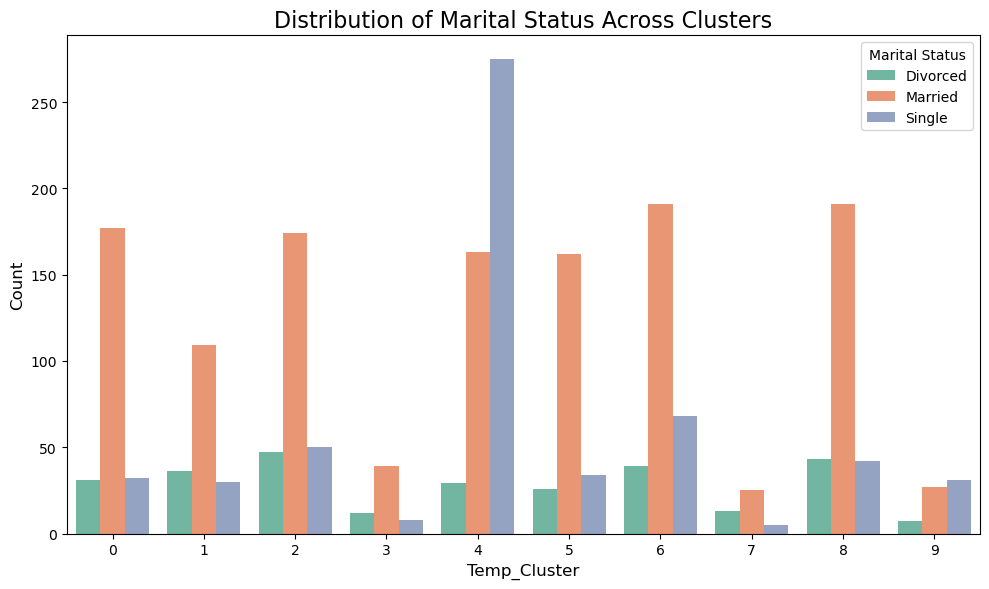

In [85]:
attributes_num = ['Income', 'Customer Lifetime Value', 'Total Claim Amount', 'Monthly Premium Auto', 'lagged_avg_sentiment_score']
attributes_cat = ['Policy', 'Education', 'Vehicle Class', 'Marital Status']

attributes_to_explore = ['Income', 'Policy Index', 'Education Index', 'Customer Lifetime Value', 'Marital Status Index',
                         'lagged_avg_sentiment_score', 'Total Claim Amount', 'Monthly Premium Auto', 'Vehicle Class Index']

kmeans = KMeans(n_clusters=10, random_state=42)
df["Temp_Cluster"] = kmeans.fit_predict(df[attributes_to_explore])

# Create density boxplots with jitter for each attribute across clusters
for attribute in attributes_num:
    plt.figure(figsize=(10, 6))
    
    # Boxplot without outliers
    sns.boxplot(x="Temp_Cluster", y=attribute, data=df, palette="viridis", showfliers=False, width=0.3)
    
    # Add jittered points for density
    sns.stripplot(x="Temp_Cluster", y=attribute, data=df, jitter=True, alpha=0.6, palette="viridis")
    
    plt.title(f"Density Boxplot of {attribute} Across Clusters", fontsize=14)
    plt.xlabel("Temp_Cluster", fontsize=12)
    plt.ylabel(attribute, fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot the bar graph
for attribute in attributes_cat:
    cluster_counts = df.groupby(['Temp_Cluster', attribute]).size().reset_index(name='count')
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=cluster_counts,  # Use the grouped data
        x='Temp_Cluster',
        y='count',
        hue=attribute,
        palette='Set2'
    )

    # Customize the plot
    plt.title(f'Distribution of {attribute} Across Clusters', fontsize=16)
    plt.xlabel('Temp_Cluster', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend(title=attribute, fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()


Once the relevant variables were selected, we proceeded with clustering and examined the distributions of these variables across clusters to determine the optimal number of clusters. Distribution plots played a critical role in this step by allowing us to visually inspect the behavior of each variable within the clusters. By using boxplots for numerical variables, we could examine the spread and central tendency of values in each cluster and identify any notable outliers. For categorical variables, barplots helped us identify dominant categories within clusters and assess their contribution to cluster differentiation.

The visualizations highlighted distinct and clear distributions for variables like `Income`, `Customer Lifetime Value`, `Policy`, `Vehicle Class`, and `Marital Status`. These variables showed minimal overlap between clusters, making them ideal for k-means clustering. This distinctiveness was essential in forming well-defined clusters and understanding how these variables contributed to segmentation.

## K-Means Clustering using t_SNE

### Cluster 1: `Customer Lifetime Value`, `Income`, `Monthly Premium Auto`

In [108]:
# Sample selected features
selected_features = ['lagged_avg_sentiment_score', 'Customer Lifetime Value', 'Income', 'Monthly Premium Auto']

# Assuming df is your original DataFrame
X = df[selected_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of K to try (convert to a list)
k_values = list(range(2, 11))

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(score)

# Create a subplot with 1 row and 3 columns
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Silhouette Score vs. Number of Clusters (K)",
        "Cluster Visualization with t-SNE (Optimal K)",
        "Cluster Visualization with t-SNE (more clusters, k=5)"
    ),
    horizontal_spacing=0.1
)

# Plot silhouette scores in the first subplot
fig.add_trace(
    go.Scatter(x=k_values, y=sil_scores, mode='markers+lines', name="Silhouette Score",
               hovertemplate='Number of Clusters: %{x}<br>Silhouette Score: %{y}<extra></extra>'),
    row=1, col=1
)

# Find the optimal K with the highest silhouette score
optimal_k = k_values[sil_scores.index(max(sil_scores))]
print(f'Optimal K: {optimal_k}')

# Perform K-Means clustering for optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

hover_data = df[selected_features].copy()
hover_data['Cluster'] = df['Cluster']

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features)

# Find features with the highest variance across clusters
important_features = centroids.var(axis=0).sort_values(ascending=False)
print(important_features)

# Perform t-SNE and plot cluster visualization for optimal_k
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

fig.add_trace(
    go.Scatter(
        x=df['t-SNE_1'],
        y=df['t-SNE_2'],
        mode='markers',
        marker=dict(color=df['Cluster'], colorscale='Viridis', size=8),
        name='Cluster Points',
        customdata=hover_data.values,
        hovertemplate='t-SNE X: %{x}<br>t-SNE Y: %{y}' +
                      ''.join([f'<br>{col}: %{{customdata[{i}]}}' for i, col in enumerate(hover_data.columns)]) +
                      '<extra></extra>',
        text=df['Cluster'],
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=centroids['t-SNE_1'],
        y=centroids['t-SNE_2'],
        mode='markers',
        marker=dict(color='red', size=11, symbol='x'),
        name='Cluster Centroids',
        hovertemplate='Centroid X: %{x}<br>Centroid Y: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# Perform K-Means clustering for k=5
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

hover_data = df[selected_features].copy()
hover_data['Cluster'] = df['Cluster']

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features)

# Find features with the highest variance across clusters
important_features = centroids.var(axis=0).sort_values(ascending=False)
print(important_features)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Add cluster labels to data
df['Cluster'] = clusters

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

# Perform t-SNE and plot cluster visualization for k=5
X_embedded = tsne.fit_transform(X_scaled)

fig.add_trace(
    go.Scatter(
        x=df['t-SNE_1'],
        y=df['t-SNE_2'],
        mode='markers',
        marker=dict(color=df['Cluster'], colorscale='Viridis', size=8),
        name='Cluster Points',
        customdata=hover_data.values,
        hovertemplate='t-SNE X: %{x}<br>t-SNE Y: %{y}' +
                      ''.join([f'<br>{col}: %{{customdata[{i}]}}' for i, col in enumerate(hover_data.columns)]) +
                      '<extra></extra>',
        text=df['Cluster'],
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(
        x=centroids['t-SNE_1'],
        y=centroids['t-SNE_2'],
        mode='markers',
        marker=dict(color='red', size=11, symbol='x'),
        name='Cluster Centroids',
        hovertemplate='Centroid X: %{x}<br>Centroid Y: %{y}<extra></extra>'
    ),
    row=1, col=3
)

# Adjust the layout to make the plot larger horizontally
fig.update_layout(
    width=1350,
    height=500,
    title="Cluster Analysis",
    title_x=0.5,
    showlegend=True
)

# Show the figure
fig.show()



/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-pac

Optimal K: 2
Customer Lifetime Value       1.798437
Monthly Premium Auto          1.577740
Income                        0.001217
lagged_avg_sentiment_score    0.001176
dtype: float64


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Monthly Premium Auto          2.067219
Customer Lifetime Value       1.864715
lagged_avg_sentiment_score    0.824819
Income                        0.404464
dtype: float64


The Silhouette score was used to determine the optimal number of clusters, identifying \( k=2 \) as the best choice. To visualize the clusters, we applied t-SNE for dimensionality reduction and plotted the clusters for both \( k=2 \) and a larger \( k=5 \). The t-SNE plots revealed that the clusters were not clearly separable. Also, since the goal was to explore the relationship between `lagged_avg_sentiment_score` and other variables, we adjusted the clustering approach to prioritize this variable and considered a larger \( k \) for better-defined clusters. Finally, we examined the correlations between `lagged_avg_sentiment_score` and variables such as `Customer Lifetime Value`, `Income`, and `Monthly Premium Auto` within each cluster, which revealed relationships between sentiment scores and these variables.

In [88]:
df_numeric = df[['lagged_avg_sentiment_score', 'Customer Lifetime Value', 'Income', 'Monthly Premium Auto', 'Cluster']]

for cluster in df_numeric['Cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_data = df_numeric[df_numeric['Cluster'] == cluster]
    print(cluster_data.corr()['lagged_avg_sentiment_score'])


Cluster 4:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value       0.014924
Income                       -0.039060
Monthly Premium Auto          0.000466
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 0:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value       0.013525
Income                       -0.063500
Monthly Premium Auto          0.040972
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 3:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value      -0.084488
Income                       -0.049478
Monthly Premium Auto         -0.077793
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 1:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value      -0.128715
Income                       -0.073325
Monthly Premium Auto         -0.000165
Cluster                            NaN
Name: lagged_avg_sentiment_sc

The correlations between `lagged_avg_sentiment_score` and other variables across clusters show consistent but weak relationships. In particular, sentiment scores exhibit small negative correlations with `Income` across all clusters, suggesting that individuals with lower incomes may tend to have more positive sentiment scores. Similarly, weak negative correlations with `Customer Lifetime Value` and `Monthly Premium Auto` are observed in some clusters, with a slightly stronger negative trend for `Monthly Premium Auto` in Cluster 2. Overall, these weak correlations suggest that sentiment is only minimally influenced by these variables, and any trends may vary depending on the cluster.

### Cluster 2: `lagged_avg_sentiment_score`, `Customer Lifetime Value`, `Total Claim Amount`, `Vehicle Class Index`, `Marital Status Index`

In [109]:
selected_features = ['lagged_avg_sentiment_score', 'Customer Lifetime Value', 'Total Claim Amount', 'Vehicle Class Index', 'Marital Status Index']

# Assuming df is your original DataFrame
X = df[selected_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of K to try (convert to a list)
k_values = list(range(2, 11))

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(score)

# Create a subplot with 1 row and 3 columns
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Silhouette Score vs. Number of Clusters (K)",
        "Cluster Visualization with t-SNE (Optimal K)",
        "Cluster Visualization with t-SNE (more clusters, k=9)"
    ),
    horizontal_spacing=0.1
)

# Plot silhouette scores in the first subplot
fig.add_trace(
    go.Scatter(x=k_values, y=sil_scores, mode='markers+lines', name="Silhouette Score",
               hovertemplate='Number of Clusters: %{x}<br>Silhouette Score: %{y}<extra></extra>'),
    row=1, col=1
)

# Find the optimal K with the highest silhouette score
optimal_k = k_values[sil_scores.index(max(sil_scores))]
print(f'Optimal K: {optimal_k}')

# Perform K-Means clustering for optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

hover_data = df[selected_features].copy()
hover_data['Cluster'] = df['Cluster']

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features)

# Find features with the highest variance across clusters
important_features = centroids.var(axis=0).sort_values(ascending=False)
print(important_features)

# Perform t-SNE and plot cluster visualization for optimal_k
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

fig.add_trace(
    go.Scatter(
        x=df['t-SNE_1'],
        y=df['t-SNE_2'],
        mode='markers',
        marker=dict(color=df['Cluster'], colorscale='Viridis', size=8),
        name='Cluster Points',
        customdata=hover_data.values,
        hovertemplate='t-SNE X: %{x}<br>t-SNE Y: %{y}' +
                      ''.join([f'<br>{col}: %{{customdata[{i}]}}' for i, col in enumerate(hover_data.columns)]) +
                      '<extra></extra>',
        text=df['Cluster'],
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=centroids['t-SNE_1'],
        y=centroids['t-SNE_2'],
        mode='markers',
        marker=dict(color='red', size=11, symbol='x'),
        name='Cluster Centroids',
        hovertemplate='Centroid X: %{x}<br>Centroid Y: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# Perform K-Means clustering for k=9
kmeans = KMeans(n_clusters=9, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

hover_data = df[selected_features].copy()
hover_data['Cluster'] = df['Cluster']

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features)

# Find features with the highest variance across clusters
important_features = centroids.var(axis=0).sort_values(ascending=False)
print(important_features)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Add cluster labels to data
df['Cluster'] = clusters

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

# Perform t-SNE and plot cluster visualization for k=5
X_embedded = tsne.fit_transform(X_scaled)

fig.add_trace(
    go.Scatter(
        x=df['t-SNE_1'],
        y=df['t-SNE_2'],
        mode='markers',
        marker=dict(color=df['Cluster'], colorscale='Viridis', size=8),
        name='Cluster Points',
        customdata=hover_data.values,
        hovertemplate='t-SNE X: %{x}<br>t-SNE Y: %{y}' +
                      ''.join([f'<br>{col}: %{{customdata[{i}]}}' for i, col in enumerate(hover_data.columns)]) +
                      '<extra></extra>',
        text=df['Cluster'],
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(
        x=centroids['t-SNE_1'],
        y=centroids['t-SNE_2'],
        mode='markers',
        marker=dict(color='red', size=11, symbol='x'),
        name='Cluster Centroids',
        hovertemplate='Centroid X: %{x}<br>Centroid Y: %{y}<extra></extra>'
    ),
    row=1, col=3
)

# Adjust the layout to make the plot larger horizontally
fig.update_layout(
    width=1350,
    height=500,
    title="Cluster Analysis",
    title_x=0.5,
    showlegend=True
)

# Show the figure
fig.show()



/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-pac

Optimal K: 2
Vehicle Class Index           1.937160
Total Claim Amount            0.653326
Customer Lifetime Value       0.439202
Marital Status Index          0.000295
lagged_avg_sentiment_score    0.000281
dtype: float64


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Customer Lifetime Value       2.116709
Vehicle Class Index           1.208191
Total Claim Amount            0.826765
lagged_avg_sentiment_score    0.799349
Marital Status Index          0.708641
dtype: float64


Similarly, the Silhouette score identified the optimal number of clusters to be \( k=2 \). The next best Silhouette score \( k=9 \) was used to define more clear clusters, and again we made sure that `lagged_avg_sentiment_score` was a factor that is important when forming clusters.

In [110]:
df_numeric = df[['lagged_avg_sentiment_score', 'Customer Lifetime Value', 'Total Claim Amount', 'Vehicle Class Index', 'Marital Status Index', 'Cluster']]

for cluster in df_numeric['Cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_data = df_numeric[df_numeric['Cluster'] == cluster]
    print(cluster_data.corr()['lagged_avg_sentiment_score'])

Cluster 6:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value       0.096116
Total Claim Amount           -0.010902
Vehicle Class Index           0.011296
Marital Status Index         -0.012381
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 0:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value      -0.028713
Total Claim Amount            0.049639
Vehicle Class Index           0.019194
Marital Status Index               NaN
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 4:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value       0.018980
Total Claim Amount           -0.014188
Vehicle Class Index          -0.000034
Marital Status Index               NaN
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 3:
lagged_avg_sentiment_score    1.000000
Customer Lifetime Value      -0.120037
Total Claim Amount           

From the plot and the correlations of variables within the cluster, we observed that customers with a higher customer lifetime value or those who are married tend to exhibit slightly lower sentiment scores in Clusters 3, 5, and 8. These clusters likely represents dissatisfied customers, particularly those with higher financial contributions. Their dissatisfaction may stem from unmet expectations or a perceived lack of value for their investment. Also, we noticed that as the total claim amount increases, the customers' sentiment score decreases, which is a result we expected.

### Cluster 3: `lagged_avg_sentiment_score`, `Monthly Premium Auto`, `Customer Lifetime Value`, `Policy Index`

In [105]:
selected_features = ['lagged_avg_sentiment_score', 'Monthly Premium Auto', 'Customer Lifetime Value', 'Policy Index']

# Assuming df is your original DataFrame
X = df[selected_features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Range of K to try (convert to a list)
k_values = list(range(2, 11))

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    
    # Calculate silhouette score
    score = silhouette_score(X_scaled, kmeans.labels_)
    sil_scores.append(score)

# Create a subplot with 1 row and 3 columns
fig = make_subplots(
    rows=1, cols=3,
    subplot_titles=(
        "Silhouette Score vs. Number of Clusters (K)",
        "Cluster Visualization with t-SNE (Optimal K)",
        "Cluster Visualization with t-SNE (more clusters, k=5)"
    ),
    horizontal_spacing=0.1
)

# Plot silhouette scores in the first subplot
fig.add_trace(
    go.Scatter(x=k_values, y=sil_scores, mode='markers+lines', name="Silhouette Score",
               hovertemplate='Number of Clusters: %{x}<br>Silhouette Score: %{y}<extra></extra>'),
    row=1, col=1
)

# Find the optimal K with the highest silhouette score
optimal_k = k_values[sil_scores.index(max(sil_scores))]
print(f'Optimal K: {optimal_k}')

# Perform K-Means clustering for optimal_k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

hover_data = df[selected_features].copy()
hover_data['Cluster'] = df['Cluster']

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features)

# Find features with the highest variance across clusters
important_features = centroids.var(axis=0).sort_values(ascending=False)
print(important_features)

# Perform t-SNE and plot cluster visualization for optimal_k
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

fig.add_trace(
    go.Scatter(
        x=df['t-SNE_1'],
        y=df['t-SNE_2'],
        mode='markers',
        marker=dict(color=df['Cluster'], colorscale='Viridis', size=8),
        name='Cluster Points',
        customdata=hover_data.values,
        hovertemplate='t-SNE X: %{x}<br>t-SNE Y: %{y}' +
                      ''.join([f'<br>{col}: %{{customdata[{i}]}}' for i, col in enumerate(hover_data.columns)]) +
                      '<extra></extra>',
        text=df['Cluster'],
    ),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(
        x=centroids['t-SNE_1'],
        y=centroids['t-SNE_2'],
        mode='markers',
        marker=dict(color='red', size=11, symbol='x'),
        name='Cluster Centroids',
        hovertemplate='Centroid X: %{x}<br>Centroid Y: %{y}<extra></extra>'
    ),
    row=1, col=2
)

# Perform K-Means clustering for k=5
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to data
df['Cluster'] = clusters

hover_data = df[selected_features].copy()
hover_data['Cluster'] = df['Cluster']

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=selected_features)

# Find features with the highest variance across clusters
important_features = centroids.var(axis=0).sort_values(ascending=False)
print(important_features)

# Add t-SNE results to the dataframe
df['t-SNE_1'] = X_embedded[:, 0]
df['t-SNE_2'] = X_embedded[:, 1]

# Add cluster labels to data
df['Cluster'] = clusters

# Compute centroids in t-SNE space
centroids = df.groupby('Cluster')[['t-SNE_1', 't-SNE_2']].mean()

# Perform t-SNE and plot cluster visualization for k=5
X_embedded = tsne.fit_transform(X_scaled)

fig.add_trace(
    go.Scatter(
        x=df['t-SNE_1'],
        y=df['t-SNE_2'],
        mode='markers',
        marker=dict(color=df['Cluster'], colorscale='Viridis', size=8),
        name='Cluster Points',
        customdata=hover_data.values,
        hovertemplate='t-SNE X: %{x}<br>t-SNE Y: %{y}' +
                      ''.join([f'<br>{col}: %{{customdata[{i}]}}' for i, col in enumerate(hover_data.columns)]) +
                      '<extra></extra>',
        text=df['Cluster'],
    ),
    row=1, col=3
)

fig.add_trace(
    go.Scatter(
        x=centroids['t-SNE_1'],
        y=centroids['t-SNE_2'],
        mode='markers',
        marker=dict(color='red', size=11, symbol='x'),
        name='Cluster Centroids',
        hovertemplate='Centroid X: %{x}<br>Centroid Y: %{y}<extra></extra>'
    ),
    row=1, col=3
)

# Adjust the layout to make the plot larger horizontally
fig.update_layout(
    width=1350,
    height=500,
    title="Cluster Analysis",
    title_x=0.5,
    showlegend=True
)

# Show the figure
fig.show()


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-pac

Optimal K: 2
Customer Lifetime Value       1.840881
Monthly Premium Auto          1.657204
lagged_avg_sentiment_score    0.001582
Policy Index                  0.001179
dtype: float64


/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/Users/sungyeonkim/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Customer Lifetime Value       2.146088
Monthly Premium Auto          2.093802
lagged_avg_sentiment_score    0.789546
Policy Index                  0.713754
dtype: float64


Likewise, we used the same approach to form the best clusters. Instead of using the optimal Silhouette score that formed two clusters, the next best Silhouette score \( k=5 \) was used to define more clear clusters, and again we made sure that `lagged_avg_sentiment_score` was a factor that is important when forming clusters.

In [92]:
df_numeric = df[['lagged_avg_sentiment_score', 'Monthly Premium Auto', 'Customer Lifetime Value', 'Policy Index', 'Cluster']]

for cluster in df_numeric['Cluster'].unique():
    print(f"Cluster {cluster}:")
    cluster_data = df_numeric[df_numeric['Cluster'] == cluster]
    print(cluster_data.corr()['lagged_avg_sentiment_score'])

Cluster 1:
lagged_avg_sentiment_score    1.000000
Monthly Premium Auto          0.062100
Customer Lifetime Value       0.021075
Policy Index                 -0.158706
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 0:
lagged_avg_sentiment_score    1.000000
Monthly Premium Auto         -0.000933
Customer Lifetime Value       0.009322
Policy Index                 -0.008895
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 3:
lagged_avg_sentiment_score    1.000000
Monthly Premium Auto         -0.096096
Customer Lifetime Value      -0.085623
Policy Index                 -0.103763
Cluster                            NaN
Name: lagged_avg_sentiment_score, dtype: float64
Cluster 2:
lagged_avg_sentiment_score    1.000000
Monthly Premium Auto          0.016594
Customer Lifetime Value      -0.108720
Policy Index                  0.010815
Cluster                            NaN
Name: lagged_avg_sentiment_sc

From the plot and the correlations of variables within the clusters, we observed that customers with higher policy index values, such as more comprehensive or expensive policies, have slightly lower sentiment scores in Clusters 1, 3, and 4. Similarly, higher premiums and higher customer lifetime value appear to reduce sentiment scores, suggesting that customers paying more may feel underserved or less satisfied with their policies.

## Interpretations

The analysis of lagged sentiment data reveals valuable patterns in customer segmentation, highlighting `Customer Lifetime Value` and `Monthly Premium Auto` as key drivers. 

Customers with higher financial contributions—such as higher premiums, lifetime value, and comprehensive policies—tend to exhibit lower sentiment scores. This trend suggests persistent dissatisfaction among high-value customers, which could influence their engagement and risk profiles in 2024.

Conversely, lower-income customers tend to maintain slightly higher and more stable sentiment scores, likely due to modest expectations and simpler, more affordable policies. The lagged analysis (2023 sentiment data vs. 2024 behavior) underscores how policy complexity and cost disproportionately affect higher-income segments, while lower-income customers experience less fluctuation in satisfaction.

These findings demonstrate the value of analyzing historical sentiment data in identifying dissatisfaction and emerging risks. By leveraging these insights, insurance companies can implement tailored strategies such as simplifying policies, enhancing transparency, and offering targeted loyalty rewards to address customer pain points. These actions can foster stronger relationships, improve customer satisfaction, and drive long-term loyalty.

Insurance companies can leverage these findings to enhance customer satisfaction by:

1. Addressing High-Value Customer Dissatisfaction:

    - Simplify complex policies and improve perceived value for high-paying customers.
    - Offer loyalty rewards or discounts for long-term customers with significant financial contributions.
<p></p>

2. Enhancing Communication and Transparency:

    - Provide clear, transparent policy terms and regular updates on benefits or changes.
    - Use proactive customer feedback mechanisms to address dissatisfaction early.
<p></p>

3. Targeting Segments with Personalized Strategies:

    - Design targeted incentives for lower-income customers to retain their positive sentiment.

By implementing these strategies, insurance companies can proactively address dissatisfaction, foster stronger relationships, and improve overall customer satisfaction and loyalty.